# ENGI E1006 - Intro to Computing for Engineers & Applied Scientists
## Group Project 2
Due: 11:59pm on Monday Nov 24

Total Points: 100

In [2]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np
# import pygame    # optional for part 6

The following function is an example illustrating how to display an image using matplotlib.

In [3]:
def image_example():
    '''should produce red,purple,green squares
    on the diagonal, over a black background'''
    # RGB indexes
    red,green,blue = range(3)
    # img array 
    # all zeros = black pixels
    # shape: (150 rows, 150 cols, 3 colors)
    img = np.zeros((150,150,3))
    for x in range(50):
        for y in range(50):
            # red pixels
            img[x,y,red] = 1.0
            # purple pixels
            # set 3 color components 
            img[x+50, y+50,:] = (.5,.0,.5)
            # green pixels
            img[x+100,y+100,green] = 1.0
    plt.imshow(img)

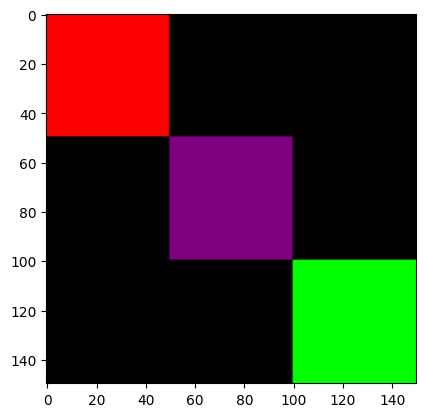

In [4]:
%matplotlib inline  
image_example()

The following functions are used to calculate the probability of a cell dying at a certain time step after being infected.

In [5]:


def normpdf(x, mean, sd):
    """
    Return the value of the normal distribution 
    with the specified mean and standard deviation (sd) at
    position x.
    You do not have to understand how this function works exactly. 
    """
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

def pdeath(x, mean, sd):
    start = x-0.5
    end = x+0.5
    step =0.01    
    integral = 0.0
    while start<=end:
        integral += step * (normpdf(start,mean,sd) + normpdf(start+step,mean,sd)) / 2
        start += step            
    return integral    
    


Some constants we will use later in the simulation: 

In [6]:
recovery_time = 4  # recovery time in time-steps
virality = 0.2       # probability that a neighbor cell is infected in each time step

# Parameters for mortality (Step 4)
death_mean = 3       # average number of steps until death
death_sd = 1         # standard deviation of steps until death


This is where your code starts.

In [7]:
class Cell(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        # "S" (susceptible), "R" (resistant / dead), "I" (infected)
        self.state = "S"
        # how many time steps this cell has been infected
        self.time = 0

    def infect(self):
        """
        Infect this cell and reset the infection timer.
        """
        self.state = "I"
        self.time = 0

    def process(self, adjacent_cells):
        """
        Process this cell for one time step.

        Only cells in state "I" (infected) change.
        Processing order for an infected cell:
        1. Check if it recovers (state I -> S).
        2. If it does not recover, check if it dies (state I -> R).
        3. If it is still infected and has been infected for at least
           one time step, attempt to infect susceptible neighbors.
        4. Finally, advance the internal infection timer.
        """
        from random import random
        global virality, recovery_time, death_mean, death_sd

        # Only infected cells change over time.
        if self.state != "I":
            return

        # 1) Recovery: if we have been infected long enough, recover.
        if self.time >= recovery_time:
            self.state = "S"
            self.time = 0
            return

        # 2) Mortality: decide if the cell dies at this time step.
        #    Use the normal-distribution-based probability pdeath.
        if random() <= pdeath(self.time, death_mean, death_sd):
            self.state = "R"
            # Once dead, we do not infect others or advance the timer further.
            return

        # 3) Infection of neighbors.
        # Newly infected cells (time == 0) cannot yet infect others.
        if self.time < 1:
            # Just advance the timer to indicate one time step has passed.
            self.time += 1
            return

        # If we reach this point, the cell is infected, has not recovered
        # or died this step, and has been infected for at least 1 step.
        for neighbor in adjacent_cells:
            if neighbor.state == "S":
                if random() <= virality:
                    neighbor.infect()

        # 4) Advance infection timer after attempting infections.
        self.time += 1


In [8]:
class Map(object):

    def __init__(self):
        self.height = 150
        self.width = 150
        self.cells = {}

    def add_cell(self, cell):
        """
        Insert a Cell object into the map at its (x, y) coordinates.
        """
        self.cells[(cell.x, cell.y)] = cell

    def display(self):
        """
        Display the current state of the map as an RGB image using matplotlib.
        Susceptible (S): green
        Infected   (I): red
        Resistant  (R): gray
        Empty      (no cell): black
        """
        red, green, blue = range(3)
        img = np.zeros((self.height, self.width, 3))

        for (x, y), cell in self.cells.items():
            if cell.state == "S":
                img[x, y, green] = 1.0
            elif cell.state == "I":
                img[x, y, red] = 1.0
            elif cell.state == "R":
                img[x, y, :] = 0.5  # gray

        plt.imshow(img)
        plt.axis("off")

    def adjacent_cells(self, x, y):
        """
        Return a list of Cell objects adjacent to (x, y).
        Adjacent = N, E, S, W (no diagonals).
        """
        neighbors = []
        directions = [
            (0, -1),   # north
            (1, 0),    # east
            (0, 1),    # south
            (-1, 0)    # west
        ]

        for dx, dy in directions:
            nx = x + dx
            ny = y + dy
            # boundary check
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if (nx, ny) in self.cells:
                    neighbors.append(self.cells[(nx, ny)])

        return neighbors

    def time_step(self):
        """
        Advance the simulation by one discrete time step.

        For each cell currently on the map:
          - compute its list of adjacent cells
          - call cell.process(adjacent_cells)
        Then display the updated map.
        """
        # Work on a snapshot so newly infected cells are processed
        # starting with the *next* time step.
        all_cells = list(self.cells.values())

        for cell in all_cells:
            adj = self.adjacent_cells(cell.x, cell.y)
            cell.process(adj)

        # After updating all cells, display the new state of the map.
        self.display()


In [9]:
def read_map(filename):
    """
    Read map data from a CSV file of "x,y" coordinate pairs and
    return a Map instance filled with Cell objects at those locations.
    """
    m = Map()

    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            x_str, y_str = line.split(",")
            x = int(x_str)
            y = int(y_str)

            cell = Cell(x, y)
            m.add_cell(cell)

    return m


In [21]:
m = read_map("nyc_map.csv")
m.cells[(39,82)].infect()

#original test case

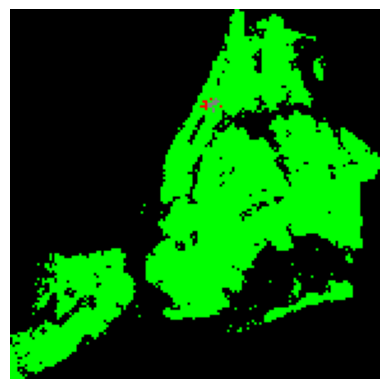

In [23]:
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.display()

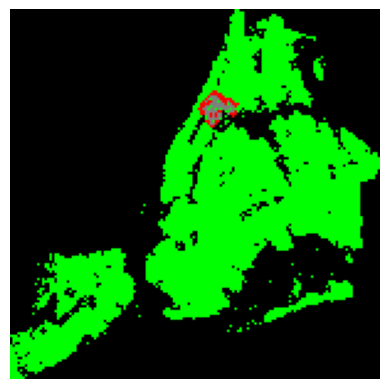

In [26]:
#new test case w/ virality 0.8

recovery_time = 4  # recovery time in time-steps
virality = 0.8      # probability that a neighbor cell is infected in each time step

# Parameters for mortality (Step 4)
death_mean = 3       # average number of steps until death
death_sd = 1         # standard deviation of steps until death

k = read_map("nyc_map.csv")
k.cells[(39,82)].infect()

m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.display()
